In [8]:
import torch
import torch.nn as nn
import numpy as np
from numpy.random import randn
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu' )
%matplotlib inline



In [9]:
class NET(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_classess):
        super(NET,self).__init__()
        self.function_1 = nn.Linear(input_size,hidden_size)
        self.function_2 = nn.Linear(hidden_size,num_classess)
        
        # Initialize the weights of the layers
        init.kaiming_normal_(self.function_1.weight)
        init.kaiming_normal_(self.function_2.weight)
    
    def forward(self,data):
        out = torch.relu(self.function_1(data))
        out = self.function_2(out)
        return out
    
    
    


In [10]:
class lossfn(nn.Module):
    
    def __init__(self,lambda_1,lambda_2):
        super(lossfn,self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
    def forward(self, y_pred, y_true, inputs):
        # y_pred is the predicted output from the neural network
        # y_true is the true output from the dataset
        # inputs is the input to the neural network
        
        # Calculate the mean squared error loss
        mse_loss = nn.MSELoss(reduction='mean')(y_pred,y_true)
        
        # Calculate the L1 and L2 regularization terms
        l1_loss = self.lambda_1 * torch.sum(torch.abs(inputs))
        l2_loss = self.lambda_2 * torch.sum(torch.square(inputs))
        
        # Combine the losses and return the total loss
        total_loss = mse_loss + l1_loss + l2_loss
        
        return total_loss

In [24]:
def train_loop(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    for batch ,(X,y) in enumerate(dataloader):
        #Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred,y)
        
        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'loss:{loss :>7f} [{current :>5d}/{size:5d}]')
            
def test_loop(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float32).to(device).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy:{(100*correct) :>0.1f}%, Avg loss:{test_loss:>8f} \n')
    
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)
    
    epochs = 10
    for t in range(epochs):
        print(f'Epoch {t+1}\n-----------------------------')
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
    print('Done!')

In [46]:
input_size,hidden_size,num_classess = 5, 8, 2
data = torch.randn(10000,input_size).to(device)
label = torch.randint(low=0,high=2,size = (10000,)).to(device)
print(data.dtype)
print(label.dtype)

torch.float32
torch.int64


In [47]:
label.unique()

tensor([0, 1], device='cuda:0')

In [48]:
X_train, X_test, y_train, y_test= train_test_split(data,label,test_size=0.2)

In [49]:
print(X_train,y_train)

tensor([[ 1.5381,  1.3471,  0.6960, -0.2497, -2.5423],
        [ 0.3119, -0.9062,  0.8503, -0.6761, -2.0199],
        [ 2.2542, -0.1696,  0.9363,  1.5105,  0.3586],
        ...,
        [-0.0253, -1.0068, -0.5249, -0.2386,  0.7222],
        [-0.0951, -1.4948,  0.9873,  0.9657, -1.1136],
        [-0.8268,  0.4982, -0.5407,  1.6149, -1.0257]], device='cuda:0') tensor([0, 0, 1,  ..., 1, 0, 0], device='cuda:0')


In [50]:
learning_rate=0.001
model = NET()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

TypeError: NET.__init__() missing 3 required positional arguments: 'input_size', 'hidden_size', and 'num_classess'

In [53]:
y_test

tensor([1, 0, 0,  ..., 0, 0, 1], device='cuda:0')

####  train the model using the custom loss function

In [51]:
model = NET(input_size,hidden_size,num_classess).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr =1e-1)
num_epochs = 5
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs) 


for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs,labels in zip(X_train,y_train):
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels )
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss:{running_loss/len(data)}")


Epoch 1 loss:0.5694627802554052
Epoch 2 loss:0.5624684980124235
Epoch 3 loss:0.5621062881469726
Epoch 4 loss:0.562123872384429
Epoch 5 loss:0.5619503389045596


In [52]:
from sklearn.metrics import confusion_matrix,classification_report
with torch.no_grad():
    model.eval()
    test_output = model(X_test)
    _, predicted = torch.max(test_output, 1)
    cm = confusion_matrix(y_test.to('cpu'), predicted.to('cpu'))
    a = classification_report(y_test.to('cpu'), predicted.to('cpu'))

print(cm)
print("\n")
print(a)
print(cm.shape)

[[ 990    0]
 [1010    0]]


              precision    recall  f1-score   support

           0       0.49      1.00      0.66       990
           1       0.00      0.00      0.00      1010

    accuracy                           0.49      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.49      0.33      2000

(2, 2)


C:\Users\johnn\anaconda3\envs\ptoch_2023\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnn\anaconda3\envs\ptoch_2023\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johnn\anaconda3\envs\ptoch_2023\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: x and y must be the same size

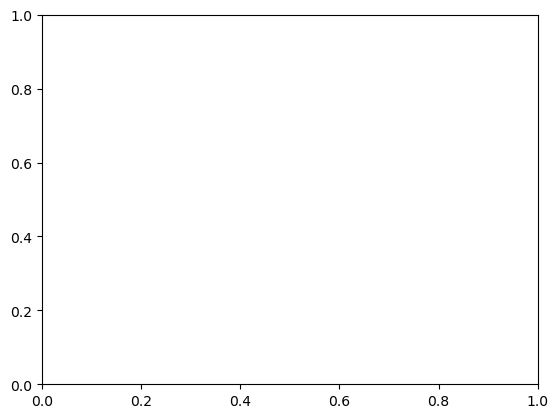

In [54]:
import matplotlib.pyplot as plt




# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_output = model(X_test).to("cuda")
    mse = criterion(test_output.squeeze(), y_test)
    test_output = test_output.squeeze()
    test_output = test_output.to("cpu")
    y_test = y_test.to("cpu")

# Visualize the predicted output versus the actual target values
plt.scatter(y_test, test_output)
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Output')
plt.title('Continuous Output of Two-Layer Neural Network')
plt.show()


In [141]:
from sklearn.metrics import confusion_matrix,classification_report
with torch.no_grad():
    model.eval()
    test_output = model(X_test)
    _, predicted = torch.max(test_output, 1)
    cm = confusion_matrix(y_test.to('cpu'), test_output.to('cpu'))
    a = classification_report(y_test.to('cpu'), predicted.to('cpu'))

print(cm)
print("\n")
print(a)
print(cm.shape)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [59]:
model.parameters

<bound method Module.parameters of NET(
  (function_1): Linear(in_features=5, out_features=8, bias=True)
  (function_2): Linear(in_features=8, out_features=11, bias=True)
)>

In [64]:
print(model(data))

tensor([[ 0.3030,  0.4417,  0.4619,  ..., -0.3199,  1.5772, -0.3071],
        [ 1.1290,  0.1408, -0.7513,  ..., -1.6019, -0.5974,  1.1672],
        [ 1.6868,  1.5111, -0.9715,  ..., -0.4391, -0.0667,  1.7803],
        ...,
        [ 1.0560,  1.6801, -0.0481,  ..., -0.5871,  1.8562,  0.4223],
        [-0.7216,  0.3228, -1.2337,  ..., -2.7042, -1.0245, -2.2581],
        [ 0.8073,  0.4416, -0.1797,  ..., -0.2013, -0.0676,  1.0251]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
from torch.utils.data import DataLoader

In [21]:
train_dataloader = DataLoader(X_train,batch_size=64)
test_dataloader = DataLoader(X_test,batch_size=64)

In [23]:
train_data_loader.dataset

tensor([[ 1.0024,  0.4693, -1.6153, -2.8466, -0.9243],
        [ 0.5554, -0.7089,  0.8280,  1.3815, -1.1755],
        [ 1.8356, -0.8979, -0.6653, -0.6493, -0.2678],
        ...,
        [ 0.3492,  0.9912, -0.9349,  0.8112,  0.1750],
        [ 0.2708, -0.5020,  0.7581,  1.4469, -0.9110],
        [ 0.1269,  0.3770, -0.5616,  0.3557,  0.3437]], device='cuda:0')